<a href="https://colab.research.google.com/github/danjaca/predicting_sales_rossmann/blob/main/Rossmann_predict_sales.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0. Imports

In [1]:
import pandas as pd
import numpy as np
import inflection
import math
import seaborn as sns
from google.colab import drive
import matplotlib.pyplot as plt


## data load

In [2]:
#dados obtidos via kaggle 
df1 = pd.read_csv('train.csv',low_memory=False)
df2 = pd.read_csv('store.csv')

In [3]:
df = df1.merge(df2,how='inner',on='Store')

In [4]:
df.head()

Store  DayOfWeek        Date  Sales  Customers  Open  Promo StateHoliday  \
0      1          5  2015-07-31   5263        555     1      1            0   
1      1          4  2015-07-30   5020        546     1      1            0   
2      1          3  2015-07-29   4782        523     1      1            0   
3      1          2  2015-07-28   5011        560     1      1            0   
4      1          1  2015-07-27   6102        612     1      1            0   

   SchoolHoliday StoreType Assortment  CompetitionDistance  \
0              1         c          a               1270.0   
1              1         c          a               1270.0   
2              1         c          a               1270.0   
3              1         c          a               1270.0   
4              1         c          a               1270.0   

   CompetitionOpenSinceMonth  CompetitionOpenSinceYear  Promo2  \
0                        9.0                    2008.0       0   
1                        9.0                    2008.0       0   
2                        9.0                    2008.0       0   
3                        9.0                    2008.0       0   
4                        9.0                    2008.0       0   

   Promo2SinceWeek  Promo2SinceYear PromoInterval  
0              NaN              NaN           NaN  
1              NaN              NaN           NaN  
2              NaN              NaN           NaN  
3              NaN              NaN           NaN  
4              NaN              NaN           NaN

# 1. Data processing

##1.1 Data clean

In [5]:
shape=df.shape
print('--o dataset contem--\nlinhas = {} \ncolunas = {}'.format(shape[0],shape[1]))

--o dataset contem--
linhas = 1017209 
colunas = 18


In [6]:
df.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

In [7]:
cols_old=['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore(x)
cols_new = list(map(snakecase,cols_old))

#renomear colunas
df.columns = cols_new
df.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval'],
      dtype='object')

In [8]:
#Date = object
df['date'] = pd.to_datetime(df['date'])
df.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

##1.2 Check NA

In [9]:
df.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

In [10]:
#competition_distance - distance in meters to the nearest competitor store
df['competition_distance']= df['competition_distance'].apply(lambda x: 200000.0 if math.isnan(x)
                                                             else x )
#competition_open_since_month
df['competition_open_since_month'] = df.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month'])
                                              else x['competition_open_since_month'],axis=1)

 
#competition_open_since_year
df['competition_open_since_year'] = df.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year'])
                                              else x['competition_open_since_year'],axis=1)
#promo2_since_week 
df['promo2_since_week'] = df.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week'])
                                              else x['promo2_since_week'],axis=1)

#promo2_since_year
df['promo2_since_year'] = df.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year'])
                                              else x['promo2_since_year'],axis=1)
#promo_interval
df['promo_interval'].fillna(0,inplace=True)

month_map = {1:'Jan',2:'Feb',3:'Mar',4:'Apr',5:'May',6:'Jun',7:'Jul',8:'Aug',9:'Sep',10:'Oct',11:'Nov',12:'Dec'}

df['month_map'] = df['date'].dt.month.map(month_map)

df['is_promo']= df[['promo_interval','month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0,axis=1)




df.isna().sum()


store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

In [11]:

df.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

In [12]:
df['competition_open_since_month'] = df['competition_open_since_month'].astype('int64')
df['competition_open_since_year'] = df['competition_open_since_year'].astype('int64')
df['promo2_since_week'] = df['promo2_since_week'].astype('int64')
df['promo2_since_year'] = df['promo2_since_year'].astype('int64')
df.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

##1.3 Descriptive Statistical

In [17]:
num_attributes = df.select_dtypes(include=['int64','float64'])
cat_attributes = df.select_dtypes(exclude=['int64','float64','datetime64[ns]'])

###1.3.1 Numerical Attributes

In [18]:
#medidas tendencia central - mean,median

ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

#medidas de dispersão - std,skew,kurtosis,min,max,range

ct3 = pd.DataFrame(num_attributes.apply( np.std ) ).T
ct4 = pd.DataFrame(num_attributes.apply( min ) ).T
ct5 = pd.DataFrame(num_attributes.apply( max ) ).T
ct6 = pd.DataFrame(num_attributes.apply( lambda x: x.skew() ) ).T
ct7 = pd.DataFrame(num_attributes.apply( lambda x: x.kurtosis() ) ).T
ct8 = pd.DataFrame(num_attributes.apply( lambda x: x.max() - x.min() ) ).T

#concatenate

metrics = pd.concat([ct4,ct5,ct8,ct1,ct2,ct3,ct7,ct6]).T.reset_index()
metrics.columns = ['attributes','min','max','range','mean','median','std','kurtosis','skew']
metrics

attributes     min       max     range         mean  \
0                          store     1.0    1115.0    1114.0   558.429727   
1                    day_of_week     1.0       7.0       6.0     3.998341   
2                          sales     0.0   41551.0   41551.0  5773.818972   
3                      customers     0.0    7388.0    7388.0   633.145946   
4                           open     0.0       1.0       1.0     0.830107   
5                          promo     0.0       1.0       1.0     0.381515   
6                 school_holiday     0.0       1.0       1.0     0.178647   
7           competition_distance    20.0  200000.0  199980.0  5935.442677   
8   competition_open_since_month     1.0      12.0      11.0     6.786849   
9    competition_open_since_year  1900.0    2015.0     115.0  2010.324840   
10                        promo2     0.0       1.0       1.0     0.500564   
11             promo2_since_week     1.0      52.0      51.0    23.619033   
12             promo2_since_year  2009.0    2015.0       6.0  2012.793297   
13                      is_promo     0.0       1.0       1.0     0.165966   

    median           std    kurtosis       skew  
0    558.0    321.908493   -1.200524  -0.000955  
1      4.0      1.997390   -1.246873   0.001593  
2   5744.0   3849.924283    1.778375   0.641460  
3    609.0    464.411506    7.091773   1.598650  
4      1.0      0.375539    1.090723  -1.758045  
5      0.0      0.485758   -1.762018   0.487838  
6      0.0      0.383056    0.815154   1.677842  
7   2330.0  12547.646829  147.789712  10.242344  
8      7.0      3.311085   -1.232607  -0.042076  
9   2012.0      5.515591  124.071304  -7.235657  
10     1.0      0.500000   -1.999999  -0.002255  
11    22.0     14.310057   -1.184046   0.178723  
12  2013.0      1.662657   -0.210075  -0.784436  
13     0.0      0.372050    1.224338   1.795644

###1.3.1 Categorical Attributes

In [19]:
cat_attributes.apply(lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

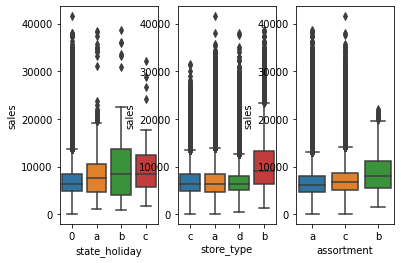

In [20]:
aux1 = df[(df['state_holiday']!=0)&(df['sales']>0)]

plt.subplot(1,3,1)
sns.boxplot(x='state_holiday',y='sales',data=aux1)

plt.subplot(1,3,2)
sns.boxplot(x='store_type',y='sales',data=aux1)

plt.subplot(1,3,3)
sns.boxplot(x='assortment',y='sales',data=aux1)



#2. FEATURE ENGINEERING

##2.1 MAPA MIND DE HIPOTESES DO FENOMENO

##2.2 CRIAÇÃO DE HIPOTESES

##2.3 DERIVAR VARIAVEIS

##2.4 FILTRAR VARIAVEIS

#3. EXPLORATORY DATA ANALYSIS

##3.1 Reponse variable

normalizar?

## 3.2 Analise univariada


### 3.2.1 numerical variables
histograma

### 3.2.2 categorical variables
countplot + kdeplot
verificar dependencias ( se os feriados tem importancia nas vendas

## 3.3 Analise Bivariada
analisar cada variavel com o fenomeno e isso inclui:
Validar Hipoteses + correlacao de pearson



##3.4 Analise multivariada

pearson pra att e cat variables entre si

#4. DATA MODELING

Normalização, Rescale(MinMax/Robust), Encoding and Transformation

#5. SELECT ATTRIBUTES

BORUTA + EXPLORATORY DATA ANALYSIS

#6. MACHINE LEARNING ALGORITHMS

##6.1 CROSS-VALIDATION

##6.2 FINE TUNING